In [66]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV #, RandomizedSearchCV
from tensorflow import keras
from tensorflow.random import set_seed
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from math import ceil, floor

import pickle

plt.style.use('seaborn')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

data_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\OptionData\\'
result_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\Neural-Network-Option-Pricing-Master-Thesis\\Code\\Results\\'
plot_path = 'C:\\Users\\oli-w\\OneDrive\\Uni\\Master Thesis\\LaTeX Template\\'

np.random.seed(seed=123)
set_seed(1234)

# 1 Prepare Data

In [2]:
T = [0.3, 1, 3]

In [3]:
def get_train_test_data(model_name):
    df = pd.read_csv(data_path + 'one_dim_{}_prices.csv'.format(model_name))
    X = np.array(df['s']).reshape(len(df), 1)
    y = np.array(df[['0.3', '1.0', '3.0']])
    X_train, X_test, y_train_all, y_test_all = train_test_split(X, y, test_size=0.2)
    y_train_dict, y_test_dict = [{0.3: y_arr.T[0], 1: y_arr.T[1], 3: y_arr.T[2]} for y_arr in (y_train_all, y_test_all)]
    return X_train, X_test, y_train_dict, y_test_dict

In [4]:
"""
Merton model data
"""

X_train_mert, X_test_mert, y_train_mert, y_test_mert = get_train_test_data('merton')

In [5]:
"""
NIG model data
"""

X_train_nig, X_test_nig, y_train_nig, y_test_nig = get_train_test_data('nig')

# 2 Train Models

## 2.1 Helper Functions

In [7]:
"""
Helper function to create model from given number of weights and hidden layers
"""

def create_model(n_weights=1000, hidden_layers=1, learning_rate=0.001):
    # formulas derived from nWeights = sum (d(l-1)+1)*d(l) for all layers l with output dim d(l)
    
    if hidden_layers == 1: # 100% of neurons in first hidden layer
        neurons = [ceil((n_weights - 1) / 3)]
    elif hidden_layers == 2: # 70% / 30% split of neurons
        x = 1/7 * (np.sqrt(21 * n_weights + 79) - 10)
        neurons = list(map(floor,[7/3 * x, x]))
    elif hidden_layers == 3: # 50% / 30% / 20% split
        x = 1/21 * (np.sqrt(84 * n_weights + 205) - 17)
        neurons = list(map(floor, [5/2 * x, 3/2 * x, x]))
    else:
        raise Exception('Only 1, 2 or 3 layers allowed')
        
    model = Sequential([Dense(neurons[0], activation='relu', input_dim=1)])
    for n in neurons[1:]:
        model.add(Dense(n, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

    return model


In [70]:
def run_grid_search(X_train, y_train):
    """
    Runs grid search for given train and test data
    """
    batch_size = [64, 128]#, 256, 512, 1024]
    learning_rate = [0.1]#, 0.01, 0.001, 0.0001]
    hidden_layers = [1]#, 2, 3]
    n_weights = [10, 30]#, 60, 100, 300, 600, 1000, 3000, 6000, 10000, 30000]
    epochs = [10, 30, 100, 300, 1000]

    #p_grid = dict(n_weights=n_weights, hidden_layers=hidden_layers, batch_size=batch_size, learning_rate=learning_rate)
    p_grid = dict(n_weights=n_weights, hidden_layers=hidden_layers, batch_size=batch_size, 
                  learning_rate=learning_rate, epochs=epochs)


    model = KerasRegressor(create_model, verbose=0)#, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=p_grid, n_jobs=-1, cv=4, verbose=1)
    grid_result = grid.fit(X_train, y_train, callbacks=[earlyStop])
    print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
    return grid_result

In [9]:
def save_results(grid_result, model_name, maturity):
    """
    Saves model performance for each parameter combination from a grid search
    for approximation of option prices from a given pricing model and maturity
    """
    columns = ['mean_fit_time', 'param_batch_size', 'param_hidden_layers', 'param_learning_rate', 
               'param_n_weights', 'param_epochs', 'mean_test_score', 'rank_test_score']
    result_df = pd.DataFrame(grid_result.cv_results_,)[columns]
    result_df.columns = ['fit_time', 'batch_size', 'hidden_layers', 'learning_rate', 'n_weights', 'epochs', 'test_score', 'rank']
    result_df[['batch_size', 'hidden_layers', 'n_weights']] = result_df[['batch_size', 'hidden_layers', 'n_weights']].astype(int)
    result_df['learning_rate'] = result_df['learning_rate'].astype('float')
    result_df['test_score'] = -result_df['test_score']
    result_df['actual_weights'] = result_df[['hidden_layers', 'n_weights']].apply(lambda x: create_model(x[1], x[0]).count_params(), axis=1)
    result_df.to_csv(result_path + 'one_dim_{}_{}_grid_search_all_results.csv'.format(model_name, maturity), index=False)
    return result_df

In [10]:
def save_best_result_overview(result_df, X_train, y_train, X_test, y_test, model_name, maturity):
    """
    Groups all results by number of weights to find parameters of best performing model for each network size
    and trains + tests neural net for each size with best parameters
    """
    idx = result_df.groupby(['n_weights'])['test_score'].transform(min) == result_df['test_score']
    overview = result_df[idx].sort_values('n_weights')
    overview = overview.drop(['actual_weights', 'rank'], axis=1)
    overview = overview[['n_weights', 'hidden_layers', 'test_score', 'learning_rate', 'batch_size', 'epochs', 'fit_time']]
    overview.columns = ['Weights', 'Hidden Layers', 'Validation MSE', 'Learning Rate', 'Batch Size', 'Epochs (CV)', 'Training Time (s)']
    overview['Validation MSE'] = overview['Validation MSE'].apply(lambda x: '{:.2e}'.format(x))
    overview['Learning Rate'] = overview['Learning Rate'].apply(lambda x: '{:g}'.format(x))
    overview['Training Time (s)'] = overview['Training Time (s)'].apply(lambda x: '{:.2f}'.format(x))
    test_mse = []
    train_epochs = []
    earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)    
    for weights, hidden, lr, batch in zip(overview['Weights'], overview['Hidden Layers'], 
                                          overview['Learning Rate'], overview['Batch Size']):
        model = create_model(weights, hidden, float(lr))
        hist = model.fit(X_train, y_train, epochs=5000, batch_size=batch, verbose=0, callbacks=[earlyStop])
        test_mse.append(model.evaluate(X_test, y_test))
        train_epochs.append(hist.epoch[-1])
    overview['Test MSE'] = test_mse
    overview['Epochs'] = train_epochs
    overview['Test MSE'] = overview['Test MSE'].apply(lambda x: '{:.2e}'.format(x))
    overview.to_csv(result_path + 'one_dim_{}_{}_overview.csv'.format(model_name, maturity), index=False)
    return overview

## 2.2 Merton Prices

In [71]:
grid_result = {}
for t in T:
    grid_result[t] = run_grid_search(X_train_mert, y_train_mert[t])

Fitting 4 folds for each of 4 candidates, totalling 16 fits
Best: -0.00010234642650175374 using {'batch_size': 64, 'hidden_layers': 1, 'learning_rate': 0.1, 'n_weights': 30}
Fitting 4 folds for each of 4 candidates, totalling 16 fits


PicklingError: Could not pickle the task to send it to the workers.

In [ ]:
all_results = {}
for t in T:
    all_results[t] = save_results(grid_result[t], 'merton', t)

In [ ]:
overview = {}
for t in T:
    overview[t] = save_best_result_overview(all_results[t], X_train_mert, y_train_mert[t], X_test_mert, y_test_mert[t],
                                            'merton', t)
    print(overview[t].to_latex(index=False))
    print('\n')

In [ ]:
for t in T:
    print('T = {}'.format(t))
    display(overview[t])

In [87]:
earlyStop = keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)  

In [155]:
model = create_model(30000, 1, 0.0001)
ist = model.fit(X_train_mert, y_train_mert[1], epochs=5000, batch_size=128, verbose=1, callbacks=[earlyStop])

Epoch 1/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0189
Epoch 2/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0046
Epoch 3/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0030
Epoch 4/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0023
Epoch 5/5000
63/63 [==============================] - 0s 5ms/step - loss: 0.0017
Epoch 6/5000
63/63 [==============================] - 0s 6ms/step - loss: 0.0013
Epoch 7/5000
63/63 [==============================] - 0s 6ms/step - loss: 8.6153e-04
Epoch 8/5000
63/63 [==============================] - 0s 6ms/step - loss: 5.5981e-04
Epoch 9/5000
63/63 [==============================] - 0s 6ms/step - loss: 3.5982e-04
Epoch 10/5000
63/63 [==============================] - 0s 6ms/step - loss: 2.4724e-04
Epoch 11/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.7845e-04
Epoch 12/5000
63/63 [==============================] - 0s 6ms/step - loss: 1.3025e-04
E

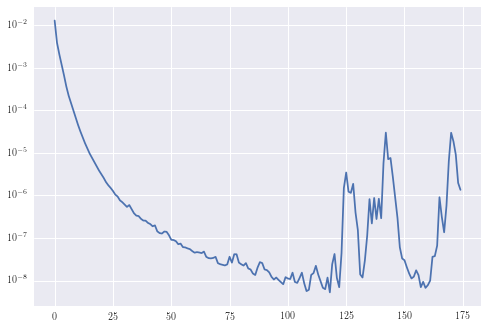

In [151]:
plt.plot(hist.history['loss'])
plt.yscale('log')

In [65]:
model.evaluate(X_test_mert, y_test_mert[1])

63/63 [==============================] - 0s 2ms/step - loss: 5.4685e-08


5.4684953454398055e-08